In [1]:
# importing relevant packages

import tweepy
import pandas as pd
import matplotlib.pyplot as plt
import squarify
import numpy as np

In [2]:
# Twitter API tokens

consumer_key = 'Key'
consumer_secret = 'Key'
access_token = 'Key'
access_token_secret = 'Key' 
bearer_token='Key'

In [3]:
# create Client object

client = tweepy.Client(bearer_token, consumer_key, consumer_secret, access_token, access_token_secret)

In [4]:
# Create function to fetch tweets from a twitter account

def fetch_tweets(username):
    
    """Fetching all tweets from a Twitter account.

    Args:
        username(str): The Twitter username to fetch the tweets from. Not case-sensitive. Starting with @ is optional.

    Returns:
        (pandas dataframe): a dataframe with the fetched tweets.
        EXCEPTION (str): For non-existent username or account with 0 tweets, this function returns a string with explanation.
    """    
    # removing @ in the handle if necessary
    if username[0] == '@':
        username = username[1:]

    # get user ID from the username
    try:
        user_id = client.get_user(username=username)[0].id
    except AttributeError:
        # handling nonexistent username
        return f'There is no username @{username} on Twitter'
    
    
    # fetching tweets
    id_list = []
    text_list = []
    l = 100
    first = True

    while l == 100:
        # tweets has to be defined first before we can fetch pagination token for next pages, therefore we define bool first to fetch the first page
        if first:
            tweets = client.get_users_tweets(user_id, max_results=100)
            first = False
        else:
            tweets = client.get_users_tweets(user_id, max_results=100, pagination_token=tweets.meta.get('next_token'))
            
        # handling cases if the amount of tweets is exact multiplication of 100
        if tweets.data is None:
            break
        else:
            for tweet in tweets.data:
                id_list.append(tweet.id)
                text_list.append(tweet.text)

        l = len(tweets.data)
        
    # Creating a pandas DataFrame with columns id (tweet ID) and text (tweet content)
    df = pd.DataFrame({
        'id'   : id_list,
        'text' : text_list
    })
    
    # handling accounts with 0 tweets
    if df.shape[0] == 0:
        return f"The twitter account @{username} has 0 tweets"
    
    return df


In [5]:
def retweets(username):
    """Identifying if a tweet is a retweet and gives the original tweet source. This function builds on fetch_tweets() function.

    Args:
        username(str): The Twitter username to fetch the tweets from. Not case-sensitive. Starting with @ is optional.

    Returns:
        (pandas dataframe): a dataframe with the fetched tweets identified as retweets with the original tweet source.
        EXCEPTION (str): For non-existent username or account with 0 tweets, this function returns a string with explanation.
    """
    df = fetch_tweets(username)
    
    # only do the operation if df is a dataframe. tried if type(df) == 'str' and if 'str' but didn't work. hasattr works because str doesn't have shape
    if hasattr(df, 'shape'):    
        # adding a column isRT (is the tweet a retweet? returns boolean)
        df['isRT'] = df['text'].apply(lambda x: 'RT @' in x)

        #adding a column RT_from (who tweeted the original tweet if it's a retweet)
        def get_rt(x):
            if x['isRT']:
                return x['text'][x['text'].find('RT @')+3:].split(sep=':')[0]    

        df['RT_from'] = df.apply(lambda x: get_rt(x), axis=1)
    
    return df

In [6]:
def rt_count(username):
    """Counts the amount and percentage of retweets based on the original tweet source. This function builds on retweets() function.

    Args:
        username(str): The Twitter username to fetch the tweets from. Not case-sensitive. Starting with @ is optional.

    Returns:
        (pandas dataframe): a dataframe with the count and percentage of retweets based on the original tweet source.
        EXCEPTION (str): For non-existent username or account with 0 tweets, this function returns a string with explanation.
    """
    df = retweets(username)
    
    # only do the operation if df is a dataframe. tried if type(df) == 'str' and if 'str' but didn't work. hasattr works because str doesn't have shape
    if hasattr(df, 'shape'):
        df_plot = df['RT_from'].value_counts(dropna=False).rename_axis('username').reset_index(name='counts')
        # username NaN means that it is an original tweet (not a retweet)
        df_plot.loc[df_plot['username'].isna(), 'username'] = 'Original Tweet'
        # splitting count and percentage to have a more granular view
        df_plot['percentage'] = df_plot['counts'].apply(lambda x: round(x/df_plot['counts'].sum()*100, 2))
        # preparing labels for plotting purposes
        df_plot['labels'] = df_plot.apply(lambda x: "{}\n({}%)".format(x['username'], x['percentage']), axis=1)
        return df_plot
    else:
        return df

In [7]:
def rt_treemap(username, auto_legend=True, num_show=0):
    """Create a treemap of tweet source of a twitter account. This function builds on rt_count() function.

    Args:
        username(str): The Twitter username to fetch the tweets from. Not case-sensitive. Starting with @ is optional.
        auto_legend(bool, optional): if True, it will show the labels for rectangles larger than 2%. If False, it will feed manually on num_show parameter.
        num_show(int, optional): This parameter is used if auto_legend is set to False. It shows how many rectangles should be labeled directly on the treemap.

    Returns:
        EXCEPTION (str): For non-existent username or account with 0 tweets, this function returns a string with explanation.
    """
    df = rt_count(username)

    # only do the operation if df is a dataframe. tried if type(df) == 'str' and if 'str' but didn't work. hasattr works because str doesn't have shape    
    if hasattr(df, 'shape'):
        fig, ax = plt.subplots(1, figsize = (12,12))
        
        # auto_legend will determine how many items will be in the legend automatically. False uses the num_show parameter for the legend calculation
        num_labels_in_legend = np.count_nonzero(np.array(df['percentage']) < 2) if auto_legend else -num_show

        # handling ax label for edge case with only 1 source
        ax_label = df['labels'] if df.shape[0] == 1 else df['labels'][:-num_labels_in_legend]
        
        # selecting the color palette plasma for treemap with majority original tweets and cividis for treemap with majority RT
        ax_color = plt.cm.plasma(np.linspace(0, 1, len(df['labels']))) if df.loc[0, 'username']=='Original Tweet' else plt.cm.cividis(np.linspace(0, 1, len(df['labels'])))

        # plot the treemap
        ax = squarify.plot(sizes=df['counts'], label=ax_label, alpha=0.5, color=ax_color, text_kwargs={'size': 9})            

        # handling manual legend calculation as well as edge case where there is only 1 source, to not show legend if everything is already labeled on the treemap
        if (num_show < df.shape[0]) & (df.shape[0] > 1):
            # set the legend item limit to max 24 because of space limitation, assuming the remaining sources are not very interesting since the retweet level is very low
            lg_limit = -num_labels_in_legend + 24 if len(df['labels'].to_list()[-num_labels_in_legend:]) >= 24 else df['labels'].shape[0]
            plt.legend(handles=ax.containers[0][-num_labels_in_legend:lg_limit], labels=df['labels'].to_list()[-num_labels_in_legend:lg_limit])
            
        # add plotting aesthetics
        ax.axis('off')
        ax.invert_xaxis()
        ax.invert_yaxis()
        ax.set_aspect('equal')
        plt.title(f'Tweet Source of @{username[1:] if username[0]=="@" else username}', size=16)
        plt.show()
        
    else:
        return df


# Testing on @uu_media_comms

In [8]:
fetch_tweets('uu_media_comms')

,id,text
0,1503327371084115976,RT @seanphelan8: Great to have @mwkrzyzanowski...
1,1498222390937010176,"RT @brankova_m: Please, share and spread the w..."
2,1497520653406289920,RT @mwkrzyzanowski: Statement by our @UU_Unive...
3,1496378915870449664,RT @mwkrzyzanowski: Medioznawca Michał Krzyżan...
4,1493614141424246792,RT @dlovgren: Really looking forward to discus...
...,...,...
134,1336068257770508290,Info about a new fascinating project @uu_media...
135,1336066339857981442,Interesting discussion on hype surrounding AI ...
136,1336063283682537472,On our newly redesigned @uu_media_comms web pa...
137,1336021054217740290,RT @uu_media_comms: After long last we are now...


In [9]:
df = retweets('uu_media_comms')
df

,id,text,isRT,RT_from
0,1503327371084115976,RT @seanphelan8: Great to have @mwkrzyzanowski...,True,@seanphelan8
1,1498222390937010176,"RT @brankova_m: Please, share and spread the w...",True,@brankova_m
2,1497520653406289920,RT @mwkrzyzanowski: Statement by our @UU_Unive...,True,@mwkrzyzanowski
3,1496378915870449664,RT @mwkrzyzanowski: Medioznawca Michał Krzyżan...,True,@mwkrzyzanowski
4,1493614141424246792,RT @dlovgren: Really looking forward to discus...,True,@dlovgren
...,...,...,...,...
134,1336068257770508290,Info about a new fascinating project @uu_media...,False,None
135,1336066339857981442,Interesting discussion on hype surrounding AI ...,False,None
136,1336063283682537472,On our newly redesigned @uu_media_comms web pa...,False,None
137,1336021054217740290,RT @uu_media_comms: After long last we are now...,True,@uu_media_comms


In [10]:
df['isRT'].value_counts()

True     107
False     32
Name: isRT, dtype: int64

In [11]:
rt_count('uu_media_comms')

,username,counts,percentage,labels
0,@mwkrzyzanowski,79,56.83,@mwkrzyzanowski\n(56.83%)
1,Original Tweet,32,23.02,Original Tweet\n(23.02%)
2,@L_deJonge,3,2.16,@L_deJonge\n(2.16%)
3,@GinaMMasullo,3,2.16,@GinaMMasullo\n(2.16%)
4,@uu_media_comms,3,2.16,@uu_media_comms\n(2.16%)
5,@MyriaGeorgiou4,2,1.44,@MyriaGeorgiou4\n(1.44%)
6,@nechri,2,1.44,@nechri\n(1.44%)
7,@seanphelan8,2,1.44,@seanphelan8\n(1.44%)
8,@chouliaraki_l,2,1.44,@chouliaraki_l\n(1.44%)
9,@dvladek,1,0.72,@dvladek\n(0.72%)


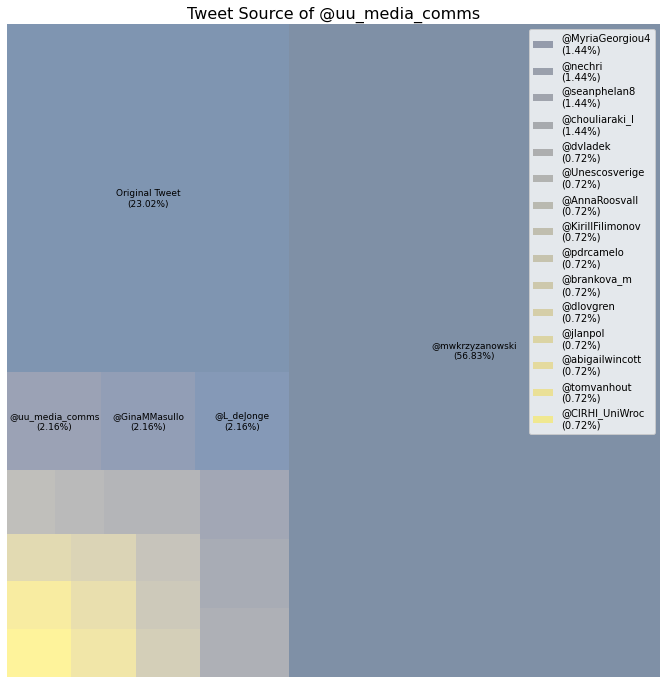

In [12]:
rt_treemap('uu_media_comms')

# Testing on various accounts

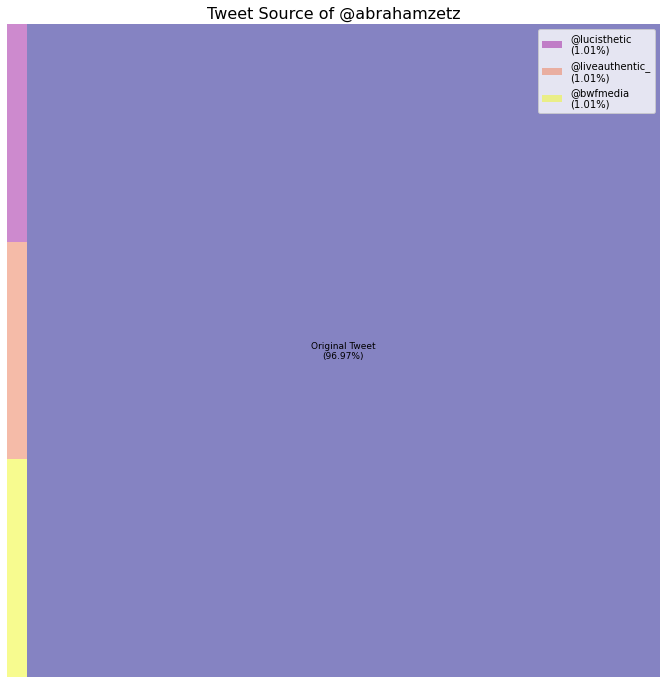

In [13]:
rt_treemap('abrahamzetz')

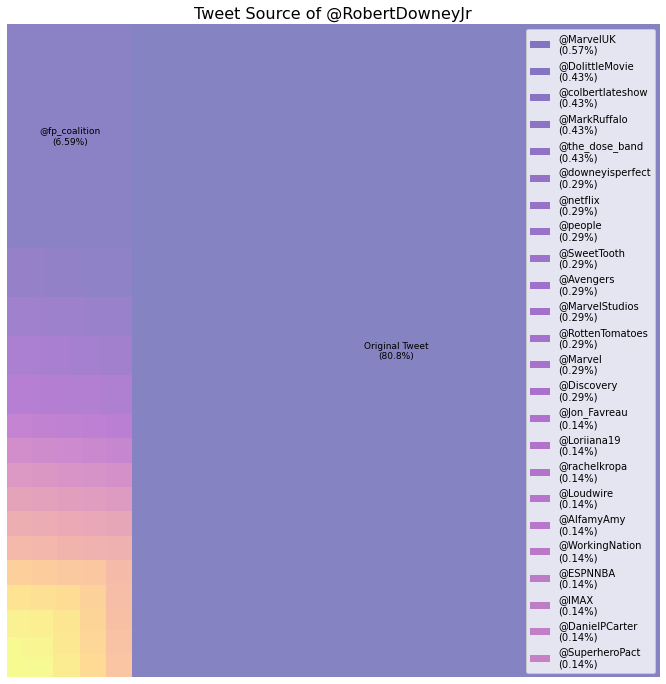

In [14]:
rt_treemap('RobertDowneyJr')

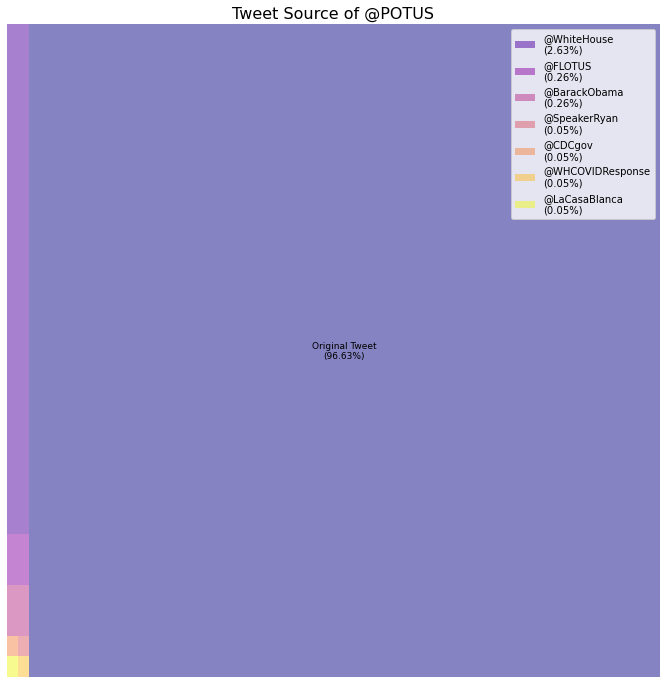

In [15]:
rt_treemap('POTUS', False, 1)

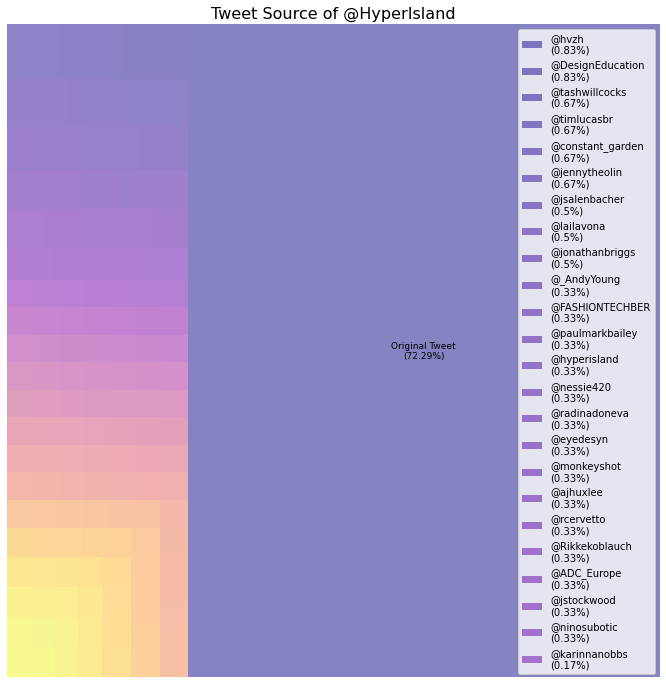

In [16]:
rt_treemap('HyperIsland')

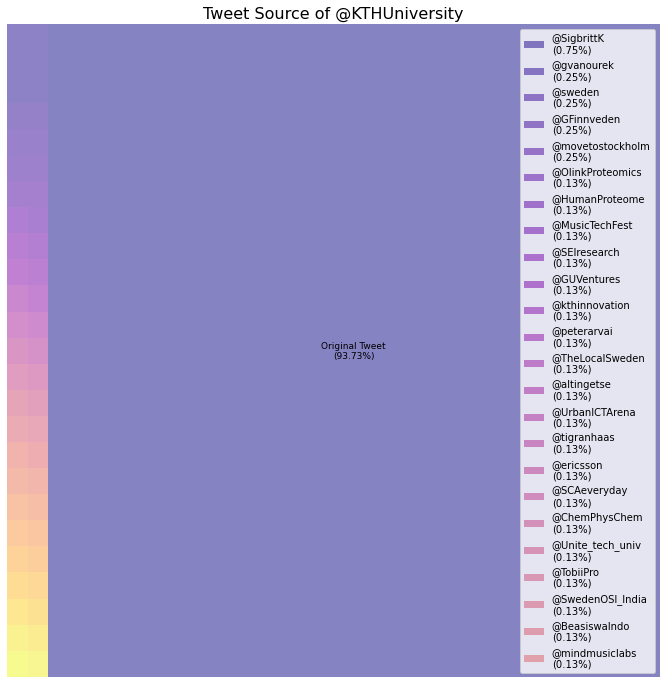

In [17]:
rt_treemap('KTHUniversity')

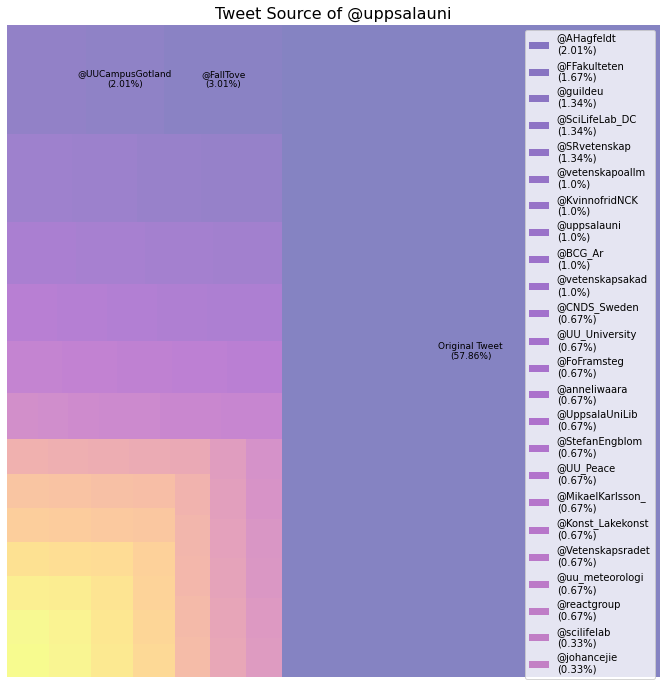

In [18]:
rt_treemap('@uppsalauni', False, 3)

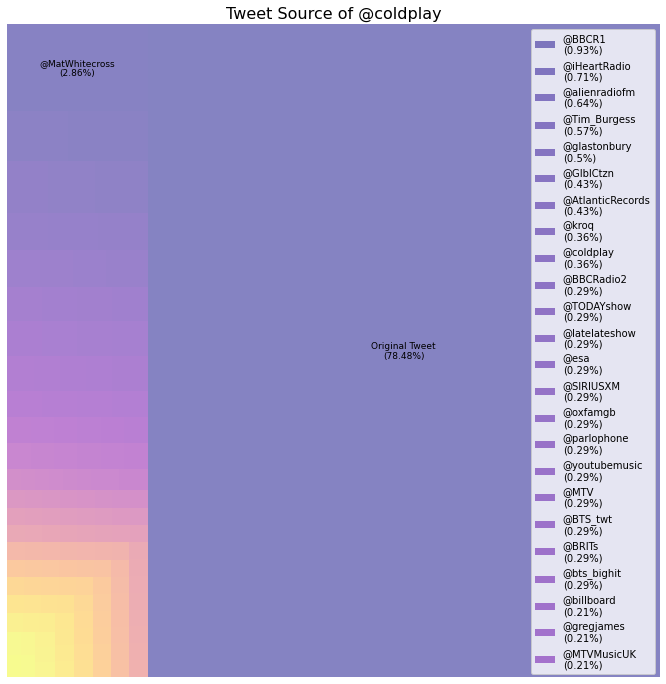

In [19]:
rt_treemap('coldplay')

# Edge cases

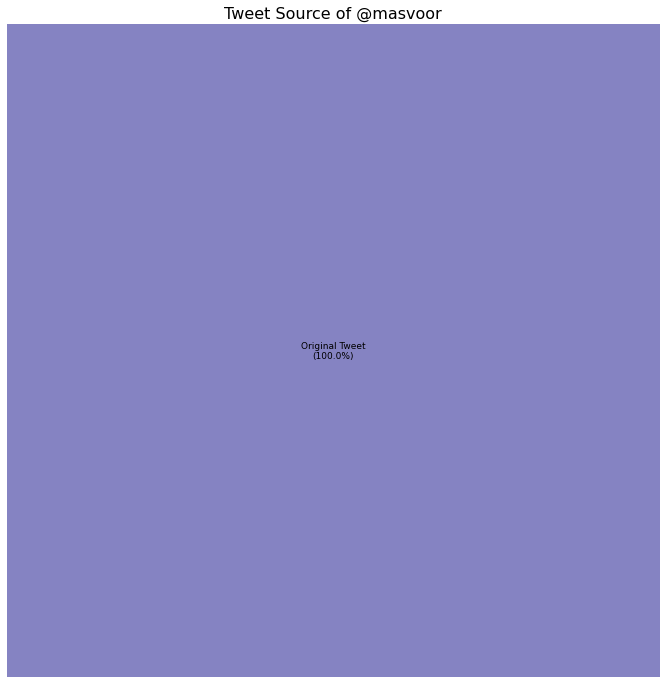

In [20]:
rt_treemap('masvoor')

In [21]:
rt_treemap('apple')

'The twitter account @apple has 0 tweets'

# Testing on Bot accounts

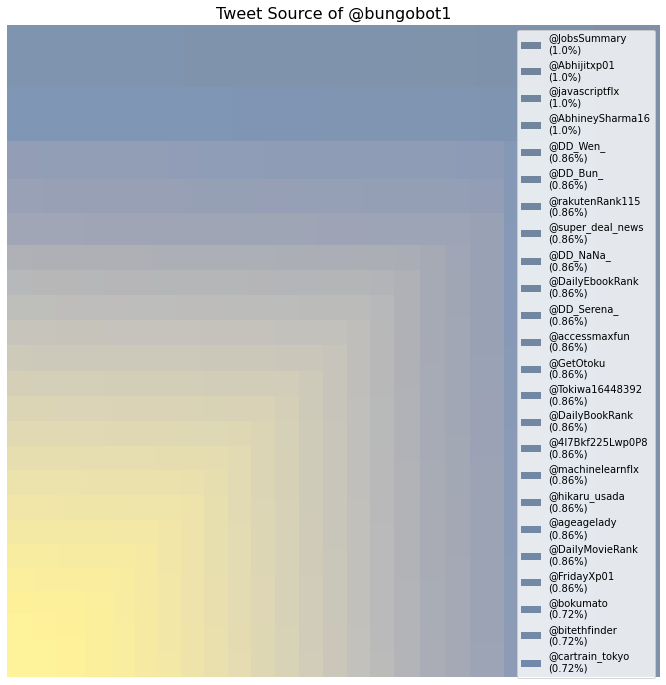

In [22]:
rt_treemap('@bungobot1')

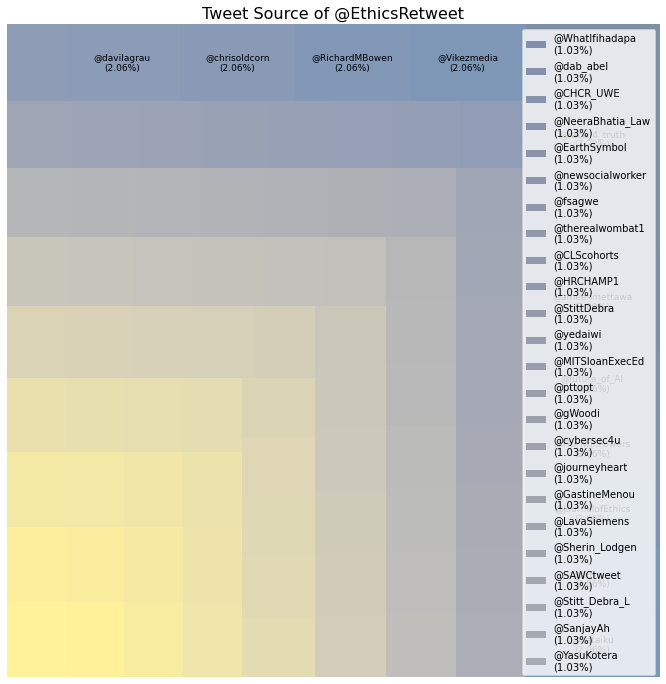

In [23]:
rt_treemap('@EthicsRetweet')